In [1]:
from astropy.table import Table
import fitsio
import numpy as np
from matplotlib import pyplot as plt
import os,sys

In [2]:
from desitarget import targetmask

# This is showing some things you can look at with the first round of "full" catalogs, which include everything up to the first MTL update

In [3]:
#where catalogs are right now
#note, anything in test is subject to sudden undocumented changes
indir = '/global/cfs/cdirs/desi/survey/catalogs/main/LSS/daily/LSScats/test/'

In [4]:
#quasars should be just about complete, except for their small-scale angular clustering, start with them

In [5]:
fq = fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/main/LSS/daily/LSScats/test/QSOzdone_full.dat.fits')

In [7]:
np.unique(fq['IS_QSO_QN'],return_counts=True)

(array([   -1,     0,     1, 16959], dtype=int16),
 array([    89, 108534, 161082,  77990]))

In [8]:
np.unique(fq['SPECTYPE'],return_counts=True)

(array(['GALAXY', 'N/A', 'QSO', 'STAR'], dtype='<U6'),
 array([110090,  77990, 150225,   9390]))

## Not every row will have an entry for spectroscopic data, as these files include everything that were possible based on how the positioners were working and the target priorities
## So, the spec columns will have null values for those rows. Above, the null values (so targets that wanted a fiber observed by a different QSO) are 16959 and 'N/A'

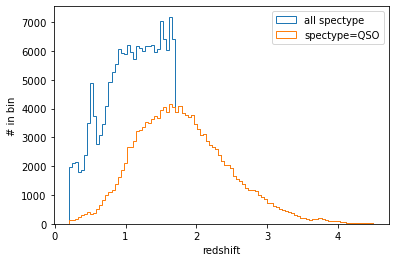

In [30]:
selobs = fq['SPECTYPE'] != 'N/A'
plt.hist(fq[selobs]['Z'],bins=100,range=(0.2,4.5),histtype='step',label='all spectype')#,density=True)
selqso = fq['SPECTYPE'] == 'QSO'
plt.hist(fq[selqso]['Z'],bins=100,range=(0.2,4.5),histtype='step',label='spectype=QSO')#,density=True)
plt.xlabel('redshift')
plt.ylabel('# in bin')
plt.legend()
plt.show()

In [36]:
#overall completeness:
tarcomp = len(fq[selobs])/len(fq)
print(tarcomp)

0.7756942147571866


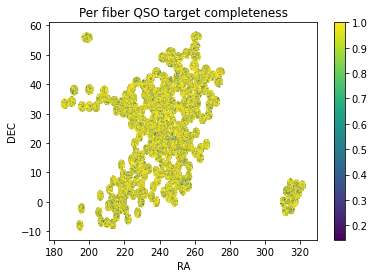

In [17]:
plt.scatter(fq[selobs]['RA'],fq[selobs]['DEC'],c=fq[selobs]['FRACZ_TILELOCID'],s=.05)
plt.colorbar()
#plt.xlim(220,240)
#plt.ylim(30,50)
plt.title('Per fiber QSO target completeness')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

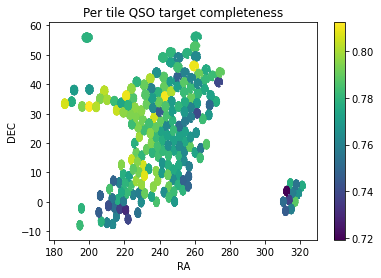

In [18]:
plt.scatter(fq[selobs]['RA'],fq[selobs]['DEC'],c=fq[selobs]['COMP_TILE'],s=.05)
plt.colorbar()
#plt.xlim(220,240)
#plt.ylim(30,50)
plt.title('Per tile QSO target completeness')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

In [21]:
fqr = fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/main/LSS/daily/LSScats/test/QSOAlltiles_0_full.ran.fits')
#there are 18 random files, numbers 0-17; 'alltiles' will switch to 'zdone' in the future in the file name

In [37]:
#randoms have density of 2500/deg2
#so, the QSO footprint size is
sqf = len(fqr)/2500
print(str(sqf)+' deg2')

1102.072 deg2


In [34]:
sellya = selobs.copy()
sellya &= fq['Z'] > 2.1
sellya |= (fq['IS_QSO_QN'] == 1) & (fq['Z_QN'] > 2.1)
print(len(fq[sellya]))

50156


In [52]:
lydens = len(fq[sellya])/sqf/tarcomp
print('The lyman-alpha density is '+str(round(lydens,2))+'/deg2')

The lyman-alpha density is 58.67/deg2


## The area is pretty big, so we can start looking for systematic trends in sky density within redshift ranges

<ipython-input-77-f8329a11767f>:6: RuntimeWarning: divide by zero encountered in log
  hd = np.histogram(np.log(qc['PSFDEPTH_R']),weights=tarcomp/qc['COMP_TILE'],range=(4.5,np.log(1500)))


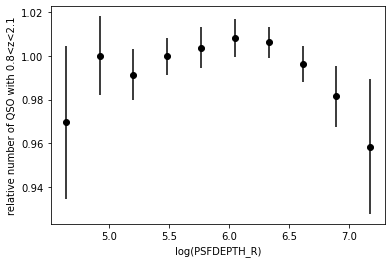

In [77]:
#just an example
selqc = fq['SPECTYPE'] == 'QSO'
selqc &= fq['Z'] > 1
selqc &= fq['Z'] < 2.1
qc = fq[selqc]
hd = np.histogram(np.log(qc['PSFDEPTH_R']),weights=tarcomp/qc['COMP_TILE'],range=(4.5,np.log(1500)))
hr = np.histogram(np.log(fqr['PSFDEPTH_R']),bins=hd[1])
norm = sum(hr[0])/sum(hd[0])
xl = hd[1][:-1]+(hd[1][1]-hd[1][0])/2.
plt.errorbar(xl,hd[0]/hr[0]*norm,np.sqrt(hd[0])/hr[0]*norm,fmt='ko')
plt.xlabel('log(PSFDEPTH_R)')
plt.ylabel('relative number of QSO with 0.8<z<2.1')
plt.show()

In [ ]:
#smoothness is strange...maybe something is not correct with approximate error-bars

## Now look at BGS

In [44]:
fb = fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/main/LSS/daily/LSScats/test/BGS_ANYzdone_full.dat.fits')

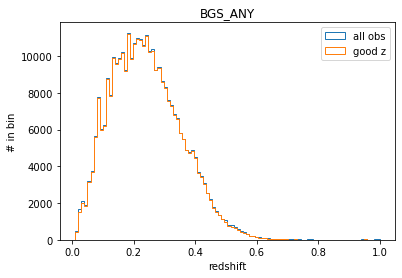

In [47]:
selobs = fb['SPECTYPE'] != 'N/A'
plt.hist(fb[selobs]['Z'],bins=100,range=(0.01,1),histtype='step',label='all obs')#,density=True)
selgz = selobs & (fb['ZWARN'] == 0)
selgz &= fb['DELTACHI2'] > 40
plt.hist(fb[selgz]['Z'],bins=100,range=(0.01,1),histtype='step',label='good z')#,density=True)
plt.xlabel('redshift')
plt.ylabel('# in bin')
plt.legend()
plt.title('BGS_ANY')
plt.show()

In [48]:
#overall completeness:
tarcompb = len(fb[selobs])/len(fb)
print(tarcompb)

0.37898076256840507


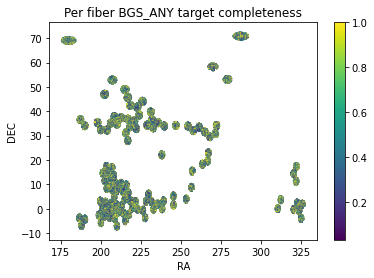

In [49]:
plt.scatter(fb[selobs]['RA'],fb[selobs]['DEC'],c=fb[selobs]['FRACZ_TILELOCID'],s=.05)
plt.colorbar()
#plt.xlim(220,240)
#plt.ylim(30,50)
plt.title('Per fiber BGS_ANY target completeness')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

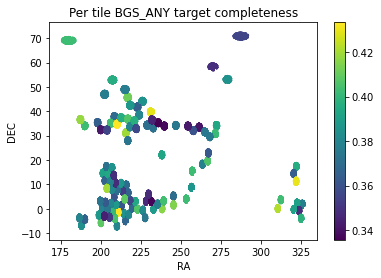

In [50]:
plt.scatter(fb[selobs]['RA'],fb[selobs]['DEC'],c=fb[selobs]['COMP_TILE'],s=.05)
plt.colorbar()
#plt.xlim(220,240)
#plt.ylim(30,50)
plt.title('Per tile BGS_ANY target completeness')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

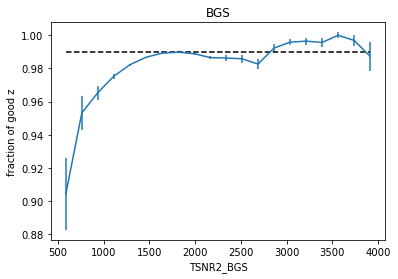

In [51]:
#Look at redshift efficiency
tp = 'BGS'
wg = fb['ZWARN'] != 999999
wzg = fb['ZWARN'] == 0
wzg &= fb['DELTACHI2'] > 40

rng = (500,4000)
nb = 20
bs = (rng[1]-rng[0])/nb    

b = np.histogram(fb[wg]['TSNR2_'+tp],bins=nb,range=rng)
a = np.histogram(fb[wzg]['TSNR2_'+tp],bins=b[1])
dl = a[0]/b[0]#/fr
varl = dl*a[0]*(1.-dl) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
el = np.sqrt(varl)/b[0]#/fr
vs = a[1][:-1]+bs/2.
plt.errorbar(vs,dl,el)        
plt.title(tp)
plt.xlabel('TSNR2_'+tp)
plt.ylabel('fraction of good z')
ol = np.ones(len(dl))*.99
plt.plot(vs,ol,'k--')
#plt.legend(loc='upper left')
plt.show()        

In [69]:
fbr = fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/main/LSS/daily/LSScats/test/BGS_ANYAlltiles_0_full.ran.fits')

In [70]:
#look at area again
ba = len(fbr)/2500
print(str(ba)+' deg2')

602.2804 deg2


<ipython-input-75-c4d513274e33>:9: RuntimeWarning: divide by zero encountered in log
  hd = np.histogram(np.log(bc['GALDEPTH_R']),weights=tarcompb/bc['COMP_TILE'],range=(4.5,np.log(1500)))


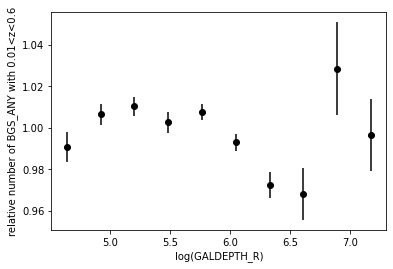

In [75]:
#just an example; note no split in BASS/MzLS / DECaLS 
selobs = fb['SPECTYPE'] != 'N/A'
selz = selobs & (fb['ZWARN'] == 0)
selz &= fb['DELTACHI2'] > 40
selz &= fb['Z'] > 0.01
selz &= fb['Z'] < 0.6

bc = fb[selz]
hd = np.histogram(np.log(bc['GALDEPTH_R']),weights=tarcompb/bc['COMP_TILE'],range=(4.5,np.log(1500)))
hr = np.histogram(np.log(fbr['GALDEPTH_R']),bins=hd[1])
norm = sum(hr[0])/sum(hd[0])
xl = hd[1][:-1]+(hd[1][1]-hd[1][0])/2.
plt.errorbar(xl,hd[0]/hr[0]*norm,np.sqrt(hd[0])/hr[0]*norm,fmt='ko')
plt.xlabel('log(GALDEPTH_R)')
plt.ylabel('relative number of BGS_ANY with 0.01<z<0.6')
plt.show()

## LRG

In [79]:
fl = fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/main/LSS/daily/LSScats/test/LRGzdone_full.dat.fits')

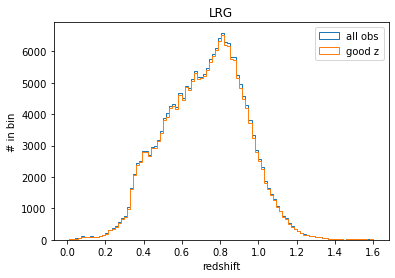

In [81]:
selobs = fl['SPECTYPE'] != 'N/A'
plt.hist(fl[selobs]['Z'],bins=100,range=(0.01,1.6),histtype='step',label='all obs')#,density=True)
selgz = selobs & (fl['ZWARN'] == 0)
selgz &= fl['DELTACHI2'] > 16
plt.hist(fl[selgz]['Z'],bins=100,range=(0.01,1.6),histtype='step',label='good z')#,density=True)
plt.xlabel('redshift')
plt.ylabel('# in bin')
plt.legend()
plt.title('LRG')
plt.show()

In [82]:
#overall completeness:
tarcompl = len(fl[selobs])/len(fl)
print(tarcompl)

0.5767302483720395


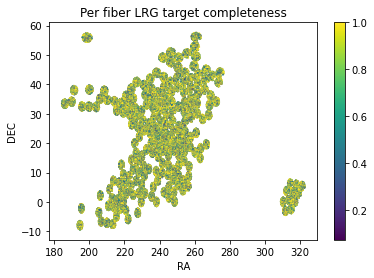

In [83]:
plt.scatter(fl[selobs]['RA'],fl[selobs]['DEC'],c=fl[selobs]['FRACZ_TILELOCID'],s=.05)
plt.colorbar()
#plt.xlim(220,240)
#plt.ylim(30,50)
plt.title('Per fiber LRG target completeness')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

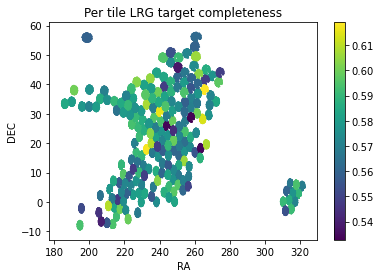

In [84]:
plt.scatter(fl[selobs]['RA'],fl[selobs]['DEC'],c=fl[selobs]['COMP_TILE'],s=.05)
plt.colorbar()
#plt.xlim(220,240)
#plt.ylim(30,50)
plt.title('Per tile LRG target completeness')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

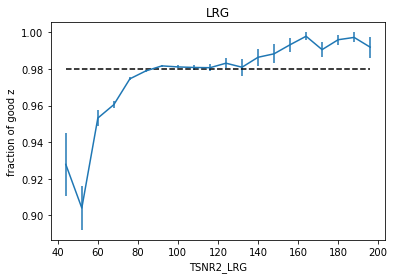

In [87]:
#Look at redshift efficiency
tp = 'LRG'
wg = fl['ZWARN'] != 999999
wzg = fl['ZWARN'] == 0
wzg &= fl['DELTACHI2'] > 16

rng = (40,200)
nb = 20
bs = (rng[1]-rng[0])/nb    

b = np.histogram(fl[wg]['TSNR2_'+tp],bins=nb,range=rng)
a = np.histogram(fl[wzg]['TSNR2_'+tp],bins=b[1])
dl = a[0]/b[0]#/fr
varl = dl*a[0]*(1.-dl) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
el = np.sqrt(varl)/b[0]#/fr
vs = a[1][:-1]+bs/2.
plt.errorbar(vs,dl,el)        
plt.title(tp)
plt.xlabel('TSNR2_'+tp)
plt.ylabel('fraction of good z')
ol = np.ones(len(dl))*.98
plt.plot(vs,ol,'k--')
#plt.legend(loc='upper left')
plt.show()        

In [92]:
flr = fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/main/LSS/daily/LSScats/test/LRGAlltiles_0_full.ran.fits')

In [93]:
#look at area again
la = len(flr)/2500
print(str(la)+' deg2')

808.8996 deg2


<ipython-input-100-0226e547c176>:9: RuntimeWarning: divide by zero encountered in log
  hd = np.histogram(np.log(lc['GALDEPTH_Z']),weights=tarcompl/lc['COMP_TILE'],range=(2.5,5.))


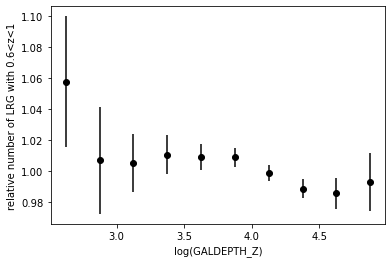

In [100]:
#just an example; note no split in BASS/MzLS / DECaLS 
selobs = fl['SPECTYPE'] != 'N/A'
selz = selobs & (fl['ZWARN'] == 0)
selz &= fl['DELTACHI2'] > 16
selz &= fl['Z'] > 0.6
selz &= fl['Z'] < 1

lc = fl[selz]
hd = np.histogram(np.log(lc['GALDEPTH_Z']),weights=tarcompl/lc['COMP_TILE'],range=(2.5,5.))
hr = np.histogram(np.log(flr['GALDEPTH_Z']),bins=hd[1])
norm = sum(hr[0])/sum(hd[0])
xl = hd[1][:-1]+(hd[1][1]-hd[1][0])/2.
plt.errorbar(xl,hd[0]/hr[0]*norm,np.sqrt(hd[0])/hr[0]*norm,fmt='ko')
plt.xlabel('log(GALDEPTH_Z)')
plt.ylabel('relative number of LRG with 0.6<z<1')
plt.show()

## And finaly ELG

In [102]:
fe = fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/main/LSS/daily/LSScats/test/ELGzdone_full.dat.fits')

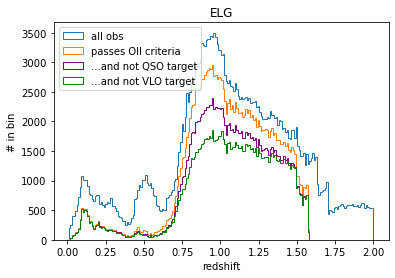

In [137]:
selobs = fe['SPECTYPE'] != 'N/A'
plt.hist(fe[selobs]['Z'],bins=200,range=(0.01,2),histtype='step',label='all obs')#,density=True)
selgz = selobs & (fe['o2c'] > 0.9)
plt.hist(fe[selgz]['Z'],bins=200,range=(0.01,2),histtype='step',label='passes OII criteria')#,density=True)
selnqgz = selgz & ((fe['DESI_TARGET'] & targetmask.desi_mask['QSO']) == 0)
plt.hist(fe[selnqgz]['Z'],bins=200,range=(0.01,2),histtype='step',label='...and not QSO target',color='purple')#,density=True)
selnvgz = selnqgz & ((fe['DESI_TARGET'] & targetmask.desi_mask['ELG_VLO']) == 0)
plt.hist(fe[selnvgz]['Z'],bins=200,range=(0.01,2),histtype='step',label='...and not VLO target',color='green')#,density=True)

plt.xlabel('redshift')
plt.ylabel('# in bin')
plt.legend(loc='upper left')
plt.title('ELG')
plt.show()

In [110]:
#overall completeness:
tarcompe = len(fe[selobs])/len(fe)
print(tarcompe)

0.2324820516430413


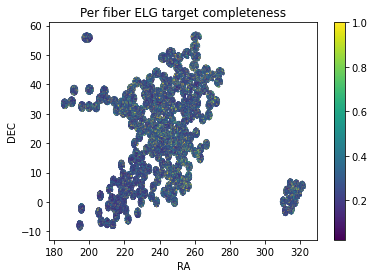

In [112]:
plt.scatter(fe[selobs]['RA'],fe[selobs]['DEC'],c=fe[selobs]['FRACZ_TILELOCID'],s=.05)
plt.colorbar()
#plt.xlim(220,240)
#plt.ylim(30,50)
plt.title('Per fiber ELG target completeness')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

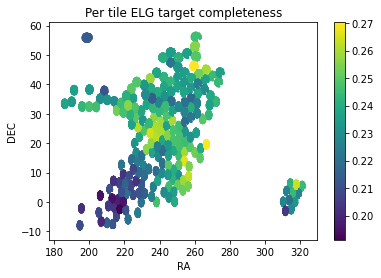

In [113]:
plt.scatter(fe[selobs]['RA'],fe[selobs]['DEC'],c=fe[selobs]['COMP_TILE'],s=.05)
plt.colorbar()
#plt.xlim(220,240)
#plt.ylim(30,50)
plt.title('Per tile ELG target completeness')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

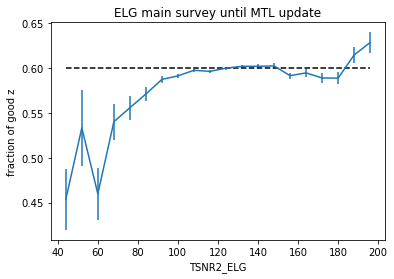

In [115]:
#Look at redshift efficiency
tp = 'ELG'
wg = fe['ZWARN'] != 999999
wzg = wg & (fe['o2c'] > 0.9)

rng = (40,200)
nb = 20
bs = (rng[1]-rng[0])/nb    

b = np.histogram(fe[wg]['TSNR2_'+tp],bins=nb,range=rng)
a = np.histogram(fe[wzg]['TSNR2_'+tp],bins=b[1])
dl = a[0]/b[0]#/fr
varl = dl*a[0]*(1.-dl) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
el = np.sqrt(varl)/b[0]#/fr
vs = a[1][:-1]+bs/2.
plt.errorbar(vs,dl,el)        
plt.title(tp+' main survey until MTL update')
plt.xlabel('TSNR2_'+tp)
plt.ylabel('fraction of good z')
#plt.legend(loc='upper left')
ol = np.ones(len(dl))*(.6)
plt.plot(vs,ol,'k--')
plt.show()        

In [118]:
selnoq = fe['DESI_TARGET'] & targetmask.desi_mask['QSO'] == 0

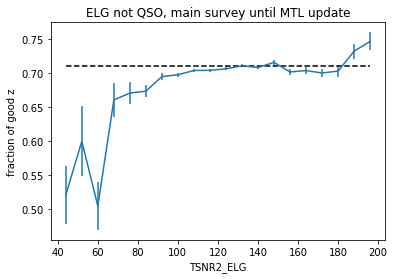

In [119]:
#repeat, removing QSO targets
tp = 'ELG'
wg = selnoq & (fe['ZWARN'] != 999999) 
wzg = wg & (fe['o2c'] > 0.9) 

rng = (40,200)
nb = 20
bs = (rng[1]-rng[0])/nb    

b = np.histogram(fe[wg]['TSNR2_'+tp],bins=nb,range=rng)
a = np.histogram(fe[wzg]['TSNR2_'+tp],bins=b[1])
dl = a[0]/b[0]#/fr
varl = dl*a[0]*(1.-dl) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
el = np.sqrt(varl)/b[0]#/fr
vs = a[1][:-1]+bs/2.
plt.errorbar(vs,dl,el)        
plt.title(tp+' not QSO, main survey until MTL update')
plt.xlabel('TSNR2_'+tp)
plt.ylabel('fraction of good z')
#plt.legend(loc='upper left')
ol = np.ones(len(dl))*(.71)
plt.plot(vs,ol,'k--')
plt.show()        

In [121]:
fer = fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/main/LSS/daily/LSScats/test/ELGAlltiles_0_full.ran.fits')

In [122]:
#look at area again
ea = len(fer)/2500
print(str(ea)+' deg2')

521.2368 deg2


<ipython-input-126-149a72d3bb51>:8: RuntimeWarning: divide by zero encountered in log
  hd = np.histogram(np.log(ec['GALDEPTH_G']),weights=tarcompe/ec['COMP_TILE'],range=(5.5,8.))


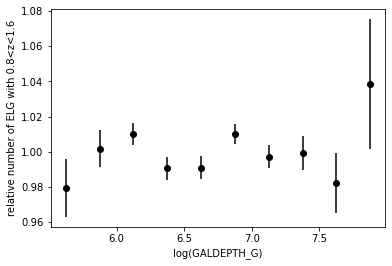

In [126]:
#just an example; note no split in BASS/MzLS / DECaLS and low completeness is probably pushing things for ELG 
selobs = fe['SPECTYPE'] != 'N/A'
selz = selobs & (fe['o2c'] > 0.9)
selz &= fe['Z'] > 0.8
selz &= fe['Z'] < 1.6

ec = fe[selz]
hd = np.histogram(np.log(ec['GALDEPTH_G']),weights=tarcompe/ec['COMP_TILE'],range=(5.5,8.))
hr = np.histogram(np.log(fer['GALDEPTH_G']),bins=hd[1])
norm = sum(hr[0])/sum(hd[0])
xl = hd[1][:-1]+(hd[1][1]-hd[1][0])/2.
plt.errorbar(xl,hd[0]/hr[0]*norm,np.sqrt(hd[0])/hr[0]*norm,fmt='ko')
plt.xlabel('log(GALDEPTH_G)')
plt.ylabel('relative number of ELG with 0.8<z<1.6')
plt.show()

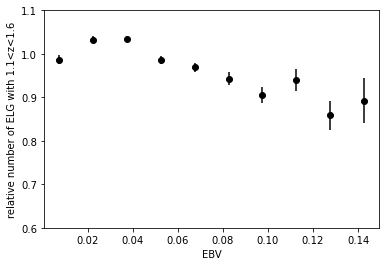

In [133]:
#just an example; note no split in BASS/MzLS / DECaLS and low completeness is probably pushing things for ELG 
selobs = fe['SPECTYPE'] != 'N/A'
selz = selobs & (fe['o2c'] > 0.9)
selz &= fe['Z'] > 1.1
selz &= fe['Z'] < 1.6

ec = fe[selz]
hd = np.histogram(ec['EBV'],weights=tarcompe/ec['COMP_TILE'],range=(0,.15))
hr = np.histogram(fer['EBV'],bins=hd[1])
norm = sum(hr[0])/sum(hd[0])
xl = hd[1][:-1]+(hd[1][1]-hd[1][0])/2.
plt.errorbar(xl,hd[0]/hr[0]*norm,np.sqrt(hd[0])/hr[0]*norm,fmt='ko')
plt.xlabel('EBV')
plt.ylabel('relative number of ELG with 1.1<z<1.6')
plt.ylim(0.6,1.1)
plt.show()

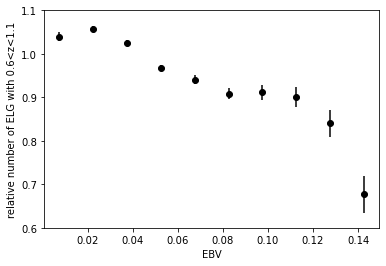

In [132]:
#just an example; note no split in BASS/MzLS / DECaLS and low completeness is probably pushing things for ELG 
selobs = fe['SPECTYPE'] != 'N/A'
selz = selobs & (fe['o2c'] > 0.9)
selz &= fe['Z'] > 0.6
selz &= fe['Z'] < 1.1

ec = fe[selz]
hd = np.histogram(ec['EBV'],weights=tarcompe/ec['COMP_TILE'],range=(0,.15))
hr = np.histogram(fer['EBV'],bins=hd[1])
norm = sum(hr[0])/sum(hd[0])
xl = hd[1][:-1]+(hd[1][1]-hd[1][0])/2.
plt.errorbar(xl,hd[0]/hr[0]*norm,np.sqrt(hd[0])/hr[0]*norm,fmt='ko')
plt.xlabel('EBV')
plt.ylabel('relative number of ELG with 0.6<z<1.1')
plt.ylim(0.6,1.1)
plt.show()

## ok, yikes, look at dN/dz split on EBV

In [139]:
selebv = fe['EBV'] > 0.04
print(len(fe[selebv]),len(fe[~selebv]))

627716 707643


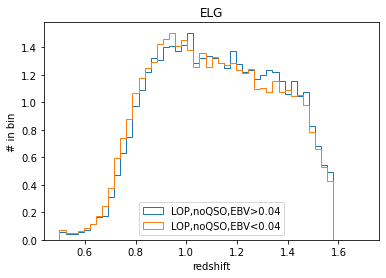

In [143]:
selobs = fe['SPECTYPE'] != 'N/A'
selgz = selobs & (fe['o2c'] > 0.9)
selnqgz = selgz & ((fe['DESI_TARGET'] & targetmask.desi_mask['QSO']) == 0)
selnvgz = selnqgz & ((fe['DESI_TARGET'] & targetmask.desi_mask['ELG_VLO']) == 0)
plt.hist(fe[selnvgz&selebv]['Z'],bins=50,range=(0.5,1.7),histtype='step',label='LOP,noQSO,EBV>0.04',density=True)
plt.hist(fe[selnvgz&~selebv]['Z'],bins=50,range=(0.5,1.7),histtype='step',label='LOP,noQSO,EBV<0.04',density=True)

plt.xlabel('redshift')
plt.ylabel('# in bin')
plt.legend(loc='lower center')
plt.title('ELG')
plt.show()

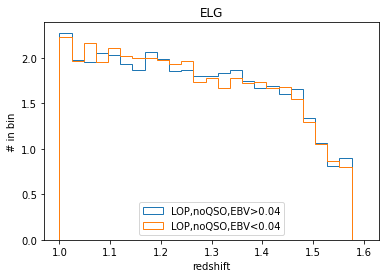

In [144]:
selobs = fe['SPECTYPE'] != 'N/A'
selgz = selobs & (fe['o2c'] > 0.9)
selnqgz = selgz & ((fe['DESI_TARGET'] & targetmask.desi_mask['QSO']) == 0)
selnvgz = selnqgz & ((fe['DESI_TARGET'] & targetmask.desi_mask['ELG_VLO']) == 0)
plt.hist(fe[selnvgz&selebv]['Z'],bins=25,range=(1,1.6),histtype='step',label='LOP,noQSO,EBV>0.04',density=True)
plt.hist(fe[selnvgz&~selebv]['Z'],bins=25,range=(1,1.6),histtype='step',label='LOP,noQSO,EBV<0.04',density=True)

plt.xlabel('redshift')
plt.ylabel('# in bin')
plt.legend(loc='lower center')
plt.title('ELG')
plt.show()

In [ ]:
# at least shape of dN/dz is not so different (and keep in mind this should really be done separately in )